In [1]:
import torch
import torch.nn as nn
import nltk
from torch.utils.data import Dataset, DataLoader
### my setup
from nltk_utils import tokenize_fn, stem_fn ,bag_of_words, train_fn , accuracy_fn
from classes import createChatDataset
from model import chatModel

## vesuale and sense 
from tqdm.auto import tqdm
from timeit import default_timer as timer
device = "cuda" if torch.cuda.is_available() else "cpu"

[nltk_data] Downloading package punkt to /home/mkh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/mkh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/ai_mkh/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### load the dataset
# Load the file with weights_only=False if you trust the source
train_dataset = torch.load("train_dataset.pt", weights_only=False)


In [3]:
classNames = train_dataset.classes
train_dataset.classes

['delivery', 'funny', 'goodbye', 'greeting', 'items', 'payments', 'thanks']

In [4]:
epochs = 500
BATCH_SIZE = 8  ## 1, 2, 8 ,16 , 32 , 64
learning_rate = 0.001
hidden_size = 8
input_feature = len(train_dataset[0][0]) # for single sample
out_feature = len(train_dataset.classes)
print(input_feature, out_feature)

52 7


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataLoader = DataLoader( dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

In [6]:
model_1 = chatModel(input_feature=input_feature , hidden_feature=hidden_size
                 , out_feature=out_feature)
criterion = loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr = learning_rate)


### train the model

In [7]:
torch.manual_seed(42)
startime = timer()
prnt = True
bar = tqdm( total = int(epochs//100) , desc = "training")
print("the training is started")
for epoch in range(epochs+1) : 
    train_fn(model=model_1, data_loader = train_dataLoader, optimizer=optimizer,
             loss_fn=loss_fn, accuracy_fn= accuracy_fn, device=device , prnt=prnt)
    if (epoch%100 == 0 ) | (epoch == 1000):
        bar.update(1)
        prnt = True
    else:
        prnt = False

endtime =timer()
print(f"total training time : {endtime-startime} sec")

training:   0%|                                           | 0/5 [00:00<?, ?it/s]

the training is started
model training loss is :  1.96864 | model accuracy: 12.5
model training loss is :  1.99541 | model accuracy: 12.5


training:  40%|██████████████                     | 2/5 [00:00<00:01,  2.44it/s]

model training loss is :  1.12266 | model accuracy: 68.75


training:  60%|█████████████████████              | 3/5 [00:01<00:01,  1.74it/s]

model training loss is :  0.12576 | model accuracy: 100.0


training:  80%|████████████████████████████       | 4/5 [00:02<00:00,  1.55it/s]

model training loss is :  0.02160 | model accuracy: 100.0


training: 100%|███████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]

model training loss is :  0.00974 | model accuracy: 100.0


training: 6it [00:04,  1.28it/s]                                                

total training time : 4.173328367003705 sec


In [8]:
import mlxtend , torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


In [9]:
import random
sentSamples , sentSampleLabels = [] , []
for sample , label  in random.sample(list(train_dataset) , k = 18) : # k number of samples
    sentSamples.append(sample) 
    sentSampleLabels.append(label) 

print( sentSamples[0].shape)


torch.Size([52])


### get the prediction data

In [10]:
predictionProb = []

model_1.eval()
with torch.inference_mode():
   for sample in sentSamples : 
       pred_out = model_1(sample)
       # predictionPr1 = torch.softmax(pred_out)
       predictionProb.append(pred_out)
pred_result = torch.stack(predictionProb)
predClasses = pred_result.argmax(dim =1)

predClasses[0] ,predictionProb [0]
    

(tensor(5),
 tensor([-7.1140, -2.4405, -2.0827, -1.4285, -1.8031,  4.6847, -6.3561]))

In [11]:
# setup the ConfusionMatrix
confMat = ConfusionMatrix(num_classes=out_feature, task='multiclass') 
confMatTensor = confMat(preds = pred_result , target = torch.tensor(sentSampleLabels))

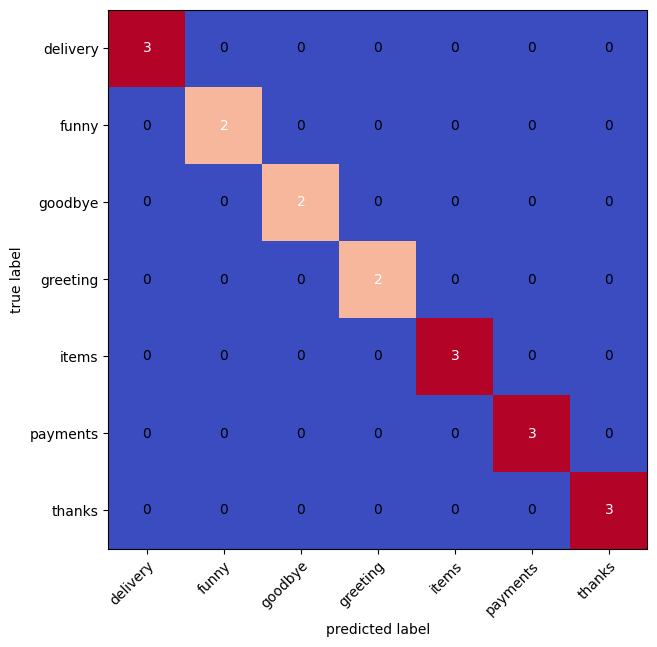

In [12]:
fig , ax = plot_confusion_matrix(
            conf_mat=confMatTensor.numpy(),
            class_names=classNames , cmap="coolwarm", 
            figsize= (7,7) )